# Alpaca Trading Workbook

### Create Class

In [8]:
# data & API packages
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame, TimeFrameUnit
import sqlite3
import pandas as pd
import time
import random
import ta
import numpy as np
from datetime import datetime, timedelta
#modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

class AlpacaTradingBot:
    """

    This class can be used to scrape stock data from the Alpaca API, store it locally in a SQLite Database,
    add indicators & perform predective analytics.

    """
    def __init__(self, keys_file_path='alpaca_keys.txt', base_url='https://paper-api.alpaca.markets', database_path=r'D:\Scripts\alpaca\alpaca_algo_trading\alpaca_data.db'):
        with open(keys_file_path, 'r') as file:
            self.api_key = file.readline().strip()
            self.api_secret = file.readline().strip()
        self.base_url = base_url
        self.api = tradeapi.REST(self.api_key, self.api_secret, base_url=base_url)
        self.database_path = database_path
        self.api_call_count = 0

    def download_bar_data(self, stock, timeframe, start_date, end_date, pause=True):
        """
        
        This method will be used to scrape bar data from the Alpaca API. 
        Provide a ticker symbol, an interval, and a beginning and end date.

        """
        all_data = []

        current_date = start_date
        while current_date <= end_date:
            # Check if it's a weekend (Saturday or Sunday) & skip, if so
            # if  datetime.strptime(current_date, "%Y-%m-%d").weekday() >= 5:
            #     current_date = (datetime.strptime(current_date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")
            #     continue

            # Split the day into two segments: midnight to noon, and noon to end of day because the API can only return 1,000 data points a day
            segments = [
                (f"{current_date}T00:00:00Z", f"{current_date}T11:59:59Z"),
                (f"{current_date}T12:00:00Z", f"{current_date}T23:59:59Z")
            ]

            for start_time, end_time in segments:
                try:
                    # Get data for the current day segment
                    bars = self.api.get_bars(stock, timeframe, start=start_time, end=end_time, limit=1000).df
                    self.api_call_count += 1  # Increment the API call counter
                    if not bars.empty:
                        bars['symbol'] = stock  # Add the stock symbol column
                        all_data.append(bars)
                        print(f"Data scraped for {current_date} through {end_time.split('T')[1]}...")
                    else:
                        print(f"No data available for segment: {current_date}: {start_time.split('T')[1]} - {end_time.split('T')[1]}")
                except tradeapi.rest.APIError as e:
                    print(f"API Error: {e}")
                    pause_duration = random.uniform(120, 240)  # Longer pause if an API error occurs
                    time.sleep(pause_duration)
                    continue
                
            # Random pause after each scrape.. API rate limits need to be considered. Only a problem for the main original pull to populate the database.
            if pause and (datetime.strptime(current_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")).days % 1 == 0:
                print(f"Total API calls made so far: {self.api_call_count}")
                pause_duration = random.uniform(10, 30)
                print(f"Pausing for {pause_duration} after scraping data for {current_date}...")
                print(f"__________________________________")
                time.sleep(pause_duration)

            # Move to the next day
            current_date = (datetime.strptime(current_date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")

        if all_data:
            combined_data = pd.concat(all_data)
            combined_data = combined_data.reset_index()  # Ensure the index is reset to have 'timestamp' as a column
            print("Scraping Bar Data complete for timerange:", combined_data['timestamp'].min(), " - ", combined_data['timestamp'].max())
            return combined_data[['symbol'] + [col for col in combined_data.columns if col not in ['symbol']]]
        else:
            return pd.DataFrame()
        
    def calculate_indicators_modeling(self, stock_data):
        """
        This method calculates various indicators on a dataframe tailored for a 1-hour trading strategy.
        """

        # Trend Indicators
        stock_data['sma_30'] = ta.trend.sma_indicator(stock_data['CLOSE'], window=30)
        # 30-minute SMA (Simple Moving Average) for medium-term trend analysis

        stock_data['ema_30'] = ta.trend.ema_indicator(stock_data['CLOSE'], window=30)
        # 30-minute EMA for a responsive short to medium-term trend

        stock_data['macd'] = ta.trend.macd(stock_data['CLOSE'], window_slow=26, window_fast=12)
        stock_data['macd_signal'] = ta.trend.macd_signal(stock_data['CLOSE'], window_slow=26, window_fast=12, window_sign=9)
        # Standard MACD (Moving Average Convergence Divergence) settings for capturing trend and momentum changes

        # Momentum Indicators
        stock_data['rsi'] = ta.momentum.rsi(stock_data['CLOSE'], window=14)
        # 14-minute RSI (Relative Strength Index) for overbought/oversold conditions

        stock_data['stochastic_k'] = ta.momentum.stoch(stock_data['HIGH'], stock_data['LOW'], stock_data['CLOSE'], window=14, smooth_window=3)
        # 14-minute Stochastic Oscillator for short-term momentum

        stock_data['cci'] = ta.trend.cci(stock_data['HIGH'], stock_data['LOW'], stock_data['CLOSE'], window=20)
        # 20-minute CCI for identifying cyclical trends

        # Volatility Indicators
        bb_indicator = ta.volatility.BollingerBands(stock_data['CLOSE'], window=20, window_dev=2)
        stock_data['bollinger_hband'] = bb_indicator.bollinger_hband()
        stock_data['bollinger_lband'] = bb_indicator.bollinger_lband()
        stock_data['bollinger_mband'] = bb_indicator.bollinger_mavg()
        stock_data['bollinger_width_percent'] = (stock_data['bollinger_hband'] - stock_data['bollinger_lband']) / stock_data['CLOSE']
        stock_data['bollinger_position'] = bb_indicator.bollinger_pband()
        # Bollinger Bands with standard deviation score for precise volatility measure

        stock_data['atr'] = ta.volatility.average_true_range(stock_data['HIGH'], stock_data['LOW'], stock_data['CLOSE'], window=14)
        # 14-minute ATR (Average True Range) for short-term volatility

        # Volume-Based Indicators
        stock_data['obv'] = ta.volume.on_balance_volume(stock_data['CLOSE'], stock_data['VOLUME'])
        # OBV (On-Balance Volume) for volume-based trend prediction

        # Calculate VWAP for each day
        stock_data['vwap'] = stock_data.groupby(stock_data['timestamp_est'].dt.date).apply(
            lambda x: (x['CLOSE'] * x['VOLUME']).cumsum() / x['VOLUME'].cumsum()
        ).reset_index(level=0, drop=True)

        return stock_data

    def transfer_stage_modeling(self, input_table, symbol, output_table=None):
        """
        
        This method cleans the scraped raw stage data, adds indicator calculations on it inserts the otuput into a fresh table.

        """
        db_path = self.database_path
        conn = sqlite3.connect(db_path)

        try:

            # Read the entire table
            input_data = pd.read_sql(f"SELECT distinct * FROM {input_table} WHERE SYMBOL = '{symbol}'" , conn)

            # Check if the input data is empty
            if input_data.empty:
                raise ValueError(f"No data found for symbol {symbol} in table {input_table}")

            # Convert 'TIMESTAMP' to datetime and localize it to UTC
            input_data['timestamp_utc'] = pd.to_datetime(input_data['TIMESTAMP'], utc=True)
            input_data['timestamp_est'] = input_data['timestamp_utc'].dt.tz_convert('US/Eastern')
            input_data['trading_hours_ind'] = (input_data['timestamp_est'].dt.time >= datetime.strptime('09:30', '%H:%M').time()) & \
                                            (input_data['timestamp_est'].dt.time <= datetime.strptime('16:00', '%H:%M').time())
            input_data['trading_hours_ind_ext'] = (input_data['timestamp_est'].dt.time >= datetime.strptime('10:30', '%H:%M').time()) & \
                                                    (input_data['timestamp_est'].dt.time <= datetime.strptime('15:00', '%H:%M').time())

            # Calculate indicators
            indicators_data = self.calculate_indicators_modeling(input_data)

            # Calculate additional features
            indicators_data['date'] = indicators_data['timestamp_est'].dt.date
            indicators_data['day_of_week'] = indicators_data['timestamp_est'].dt.dayofweek
            indicators_data['hour_of_day'] = indicators_data['timestamp_est'].dt.hour
            indicators_data['time_of_day'] = indicators_data['timestamp_est'].dt.time

            # Movement in-day & in-week as percentage
            indicators_data['daily_opening_price'] = indicators_data.groupby(indicators_data['timestamp_est'].dt.date)['OPEN'].transform('first')
            indicators_data['daily_movement_since_open'] = (indicators_data['CLOSE'] - indicators_data['daily_opening_price']) / indicators_data['daily_opening_price']

            indicators_data['weekly_opening_price'] = indicators_data.groupby(indicators_data['timestamp_est'].dt.isocalendar().week)['OPEN'].transform('first')
            indicators_data['weekly_movement_since_open'] = (indicators_data['CLOSE'] - indicators_data['weekly_opening_price']) / indicators_data['weekly_opening_price']

            # Calculate percentage movement over the last 20 periods (20 minutes)
            indicators_data['pct_movement_20_periods'] = indicators_data['CLOSE'].pct_change(periods=20)

            # Calculate percentage movement over the last 60 periods (1 hour)
            indicators_data['pct_movement_60_periods'] = indicators_data['CLOSE'].pct_change(periods=60)

            # Targets
            indicators_data['target_1_hour'] = indicators_data['CLOSE'].shift(-60)
            # Target for the closing price 1 hour from the current time, aligning with the 1-hour trading strategy
            # Calculate movement_pct and signal
            indicators_data['target_movement_pct'] = ((indicators_data['target_1_hour'] - indicators_data['CLOSE']).abs() / indicators_data['CLOSE']) * 100
            indicators_data['target_movement_signal'] = indicators_data.apply(
                lambda row: 1 if (row['target_1_hour'] - row['CLOSE']) > 0.001 * row['CLOSE'] else 
                            (-1 if (row['target_1_hour'] - row['CLOSE']) <= -0.001 * row['CLOSE'] else 0), 
                axis=1
            )

            # Drop some columns and reorder
            indicators_data = indicators_data.drop(columns=['TIMESTAMP', 'timestamp_utc'])
            indicators_data = indicators_data[['SYMBOL', 'timestamp_est', 'date', 'trading_hours_ind', 'trading_hours_ind_ext'] + [col for col in indicators_data.columns if col not in ['SYMBOL', 'timestamp_est', 'date', 'trading_hours_ind', 'trading_hours_ind_ext']]]

            # Upload data to output table if output_table is provided
            if output_table is not None:
                self.db_append(output_table, indicators_data)

        except Exception as e:
            print(f"Error processing symbol {symbol}: {e}")
    
        finally:
            conn.close()

        return indicators_data

    def db_write(self, sql_statement):
        """

        Basic functionality to execute an SQL statement against our database

        """
        db_path = self.database_path

        # Connect to the database & create a cursor object
        conn = sqlite3.connect(db_path)
        cur = conn.cursor()

        # Execute the SQL statement
        cur.execute(sql_statement)

        # Commit the changes & close the connection
        conn.commit()
        conn.close()

    def db_append(self, table_name, data_frame):
        """

        Basic functionality to append/insert a dataframe into a specified table in our database

        """
        db_path = self.database_path

        # Connect to the database
        conn = sqlite3.connect(db_path)

        # Append our dataframe into our table
        data_frame.to_sql(table_name, conn, schema='main', if_exists='append', index=False)

        # Commit the changes & close the connection
        conn.commit()
        conn.close()
        
    def db_append_no_duplicates(self, table_name, data_frame):
        """

        Variation of db_append that makes sure we aren't inserting duplicates by first checking against the primary key of the table records are being inserted into

        """
        db_path = self.database_path

        # Connect to the database
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        # Get the primary key column names
        cursor.execute(f"PRAGMA table_info({table_name})")
        table_info = cursor.fetchall()
        primary_key_columns = [column[1] for column in table_info if column[5] == 1]

        # If no primary key columns found, fall back to db_append method
        if not primary_key_columns:
            data_frame.to_sql(table_name, conn, schema='main', if_exists='append', index=False)

            # Commit the changes & close the connection
            conn.commit()
            conn.close()
            return

        # Construct the SELECT statement to fetch existing primary keys from the table
        existing_keys_query = f"SELECT {', '.join(primary_key_columns)} FROM {table_name}"
        existing_keys_df = pd.read_sql(existing_keys_query, conn)

        # Construct the composite primary key from the existing keys DataFrame
        existing_keys_df['COMPOSITE_KEY'] = existing_keys_df.apply(lambda row: tuple(row), axis=1)
        existing_keys = set(existing_keys_df['COMPOSITE_KEY'])

        # Construct the composite primary key for new records
        data_frame['COMPOSITE_KEY'] = data_frame.apply(lambda row: tuple(row[primary_key_columns]), axis=1)

        # Filter out rows with primary keys that already exist in the table
        data_frame_new_records = data_frame[~data_frame['COMPOSITE_KEY'].isin(existing_keys)]

        # Drop the composite key column
        data_frame_new_records = data_frame_new_records.drop(columns=['COMPOSITE_KEY'])

        # Append only the new rows into our table
        data_frame_new_records.to_sql(table_name, conn, schema='main', if_exists='append', index=False)

        # Commit the changes & close the connection
        conn.commit()
        conn.close()

    def classification_modeling(self, features, target, symbol):
        """
        Splits the data into training and testing sets based on provided features and target variable for a specific symbol.
        """
        conn = sqlite3.connect(self.database_path)
        df = pd.read_sql(f"SELECT * FROM SYMBOL_DATA_MODELING WHERE SYMBOL = '{symbol}' AND TRADING_HOURS_IND_EXT = 1", conn)
        conn.close()

        unique_dates = df['DATE'].unique()
        train_dates, val_dates = train_test_split(unique_dates, test_size=0.3, random_state=42)

        train_data = df[df['DATE'].isin(train_dates)]
        val_data = df[df['DATE'].isin(val_dates)]

        X_train = train_data[features]
        y_train = train_data[target]
        X_val = val_data[features]
        y_val = val_data[target]

        smote = SMOTE(random_state=42)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        models = {
            "K-Nearest Neighbors": (KNeighborsClassifier(), {
                'n_neighbors': [3, 5, 7, 9, 11, 13],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski']
            }),
            "XGBoost": (XGBClassifier(eval_metric='mlogloss'), {
                'n_estimators': [100, 200, 300],
                'max_depth': [3, 6, 9],
                'learning_rate': [0.01, 0.1, 0.2],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.8, 0.9, 1.0],
                'reg_alpha': [0, 0.1, 1],
                'reg_lambda': [1, 1.5, 2]
            }),
            "Logistic Regression": (LogisticRegression(max_iter=1000, random_state=42), {
                'penalty': ['l1', 'l2'],
                'C': [0.1, 1, 10],
                'solver': ['liblinear', 'saga'],
                'class_weight': ['balanced', None]
            }),
            "Random Forest": (RandomForestClassifier(), {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'bootstrap': [True, False],
                'class_weight': ['balanced', 'balanced_subsample', None]
            }),
            "Neural Network": (MLPClassifier(max_iter=1000, random_state=42), {
                'hidden_layer_sizes': [(50,), (100,), (150,), (100, 50), (100, 100)],
                'activation': ['relu', 'tanh', 'logistic'],
                'solver': ['adam', 'sgd', 'lbfgs'],
                'alpha': [0.0001, 0.001, 0.01, 0.1],
                'learning_rate': ['constant', 'adaptive'],
                'learning_rate_init': [0.001, 0.01, 0.1]
            }),
            "Gradient Boosting": (GradientBoostingClassifier(), {
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.01, 0.1, 0.2],
                'max_depth': [3, 4, 5, 6],
                'subsample': [0.7, 0.8, 0.9, 1.0],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }),
            "Support Vector Machine": (SVC(), {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf'],
                'class_weight': ['balanced', None]
            })
        }

        for model_name, (model, params) in models.items():
            print(f"Processing {model_name} for symbol: {symbol}")

            # Apply standardization only for SVM and Neural Network
            if model_name in ["Support Vector Machine", "Neural Network"]:
                scaler = StandardScaler()
                X_train_smote = scaler.fit_transform(X_train_smote)
                X_val = scaler.transform(X_val)

            # These are mostly performance modifications by model type... faster = can do more combos of parameters
            if model_name in ["Logistic Regression", "K-Nearest Neighbors", "XGBoost"]:
                grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, scoring='f1_weighted')
            elif model_name == "Random Forest":
                grid_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=30, cv=3, n_jobs=-1, scoring='f1_weighted', random_state=42)
            elif model_name in ["Neural Network", "Gradient Boosting"]:
                grid_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=20, cv=5, n_jobs=-1, scoring='f1_weighted', random_state=42)
            elif model_name == "Support Vector Machine":
                grid_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=3, cv=3, n_jobs=-1, scoring='f1_weighted', random_state=42)

            if model_name == "XGBoost":
                y_train_transformed = y_train_smote.replace({-1: 0, 0: 1, 1: 2})
                grid_search.fit(X_train_smote, y_train_transformed)
                best_model = grid_search.best_estimator_
                y_pred_transformed = best_model.predict(X_val)
                y_pred = pd.Series(y_pred_transformed).replace({0: -1, 1: 0, 2: 1})
            else:
                grid_search.fit(X_train_smote, y_train_smote)
                best_model = grid_search.best_estimator_
                y_pred = best_model.predict(X_val)

            f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
            cm = confusion_matrix(y_val, y_pred)
            cr = classification_report(y_val, y_pred, zero_division=0)

            # visualize & print results
            print(f"{model_name} - F1 Score: {f1}")
            print("Confusion Matrix:\n", cm)
            print("Classification Report:\n", cr)
            print("Best Hyperparameters:\n", grid_search.best_params_)
            sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d')
            plt.title(f'Confusion Matrix: {model_name}')
            plt.show()
            print(f"__________________________________")
            # Save the model with a unique filename
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            joblib.dump(best_model, f'{symbol}_{model_name}_{timestamp}.pkl')

            evaluation_results = {
                'SYMBOL': symbol,
                'MODEL_NAME': model_name,
                'F1_SCORE': f1,
                'CONFUSION_MATRIX': str(cm),
                'CLASSIFICATION_REPORT': cr,
                'BEST_PARAMS': str(grid_search.best_params_)
            }
            results_df = pd.DataFrame([evaluation_results])
            self.db_append('CLASSIFICATION_MODEL_RESULTS', results_df)

            # Feature Importance or Coefficients
            if hasattr(best_model, "feature_importances_"):
                importances = best_model.feature_importances_
                feature_importance_df = pd.DataFrame({
                    'feature': features,
                    'importance': importances
                }).sort_values(by='importance', ascending=False)
                print(f"Feature importances for {model_name}:")
                print(feature_importance_df)
            elif hasattr(best_model, "coef_"):
                coefs = best_model.coef_[0]
                coef_df = pd.DataFrame({
                    'feature': features,
                    'coefficient': coefs
                }).sort_values(by='coefficient', ascending=False)
                print(f"Coefficients for {model_name}:")
                print(coef_df)
            else:
                print(f"No feature importance or coefficients for {model_name}")
            print(f"____________________________________________")
            print(f"____________________________________________")

    def classification_model_predictions(self, input_table, symbol, output_table=None):
        """
        This method reads data from the stage table, adds indicators, makes predictions using models,
        and stores the results in a new table.
        """
        db_path = self.database_path
        conn = sqlite3.connect(db_path)

        try:
            # Step 1: Transfer stage data and add indicators
            indicators_data = self.transfer_stage_modeling(input_table, symbol)
            indicators_data.columns = indicators_data.columns.str.upper()
            indicators_data = indicators_data[indicators_data['TRADING_HOURS_IND_EXT'] == 1]

            if indicators_data.empty:
                raise ValueError(f"No data found for symbol {symbol} in table {input_table}")

            # Extract feature columns
            feature_columns = ['MACD', 'MACD_SIGNAL', 'RSI', 'STOCHASTIC_K', 'CCI', 'BOLLINGER_WIDTH_PERCENT',
                            'BOLLINGER_POSITION', 'ATR', 'OBV', 'DAILY_MOVEMENT_SINCE_OPEN', 'WEEKLY_MOVEMENT_SINCE_OPEN',
                            'PCT_MOVEMENT_20_PERIODS', 'PCT_MOVEMENT_60_PERIODS', 'DAY_OF_WEEK', 'HOUR_OF_DAY']
            
            # Ensure only the feature columns are used for prediction
            feature_data = indicators_data[feature_columns]

            # Step 2: Load models
            models = {
                "Random_Forest": joblib.load('SPY_Random Forest_20240603_103726.pkl'),
                "XGBoost": joblib.load('SPY_XGBoost_20240603_135615.pkl'),
                "Gradient_Boosting": joblib.load('SPY_Gradient Boosting_20240603_173344.pkl'),
                "Neural_Network": joblib.load('SPY_Neural Network_20240604_104103.pkl'),
            }

            # Step 3: Make predictions using each model and store the results in the DataFrame
            for model_name, model in models.items():
                print(f"Predicting with {model_name} model.")
                if model_name == "XGBoost":
                    predictions = model.predict(feature_data)
                    # Inverse transform the predictions for XGBoost
                    predictions = pd.Series(predictions).replace({0: -1, 1: 0, 2: 1}).values
                elif model_name == "Neural_Network":
                    scaler = StandardScaler()
                    X_scaled = scaler.fit_transform(feature_data)
                    predictions = model.predict(X_scaled)
                else:
                    predictions = model.predict(feature_data)
                
                indicators_data[f'{model_name}_prediction'] = predictions
                print(f"{model_name} prediction computed for {symbol}.")
                print(f"Unique predictions for {model_name}: {pd.Series(predictions).unique()}")

            # Step 4: Store the final DataFrame into the output table
            if output_table is not None:
                # Truncate the existing table
                self.db_write(f"DELETE FROM {output_table}")
                print(f"Truncated table {output_table}.")

                # Store the DataFrame in the output table
                self.db_append(output_table, indicators_data)
                print(f"Model predictions stored in {output_table}.")

        except Exception as e:
            print(f"Error processing symbol {symbol}: {e}")

        finally:
            conn.close()

        return indicators_data



### Schema DDL

In [29]:
"""

Schema DDL - creates the tables in our database that we need for storing the raw scraped data & analyzing it.

"""
atb = AlpacaTradingBot()

# This table will house the raw scraped data
# sql_statement = atb.db_write('''DROP TABLE IF EXISTS STG_SYMBOL_DATA''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS STG_SYMBOL_DATA (
#     SYMBOL                  TEXT,
#     TIMESTAMP               TIMESTAMP,
#     CLOSE                   DECIMAL,
#     HIGH                    DECIMAL,
#     LOW                     DECIMAL,
#     TRADE_COUNT             INTEGER,
#     OPEN                    DECIMAL,
#     VOLUME                  INTEGER,
#     VWAP                    DECIMAL,
#     PRIMARY KEY (SYMBOL, TIMESTAMP)
# )
# ''')

# sql_statement = atb.db_write('''DROP TABLE IF EXISTS SYMBOL_DATA_MODELING''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS SYMBOL_DATA_MODELING (
#     SYMBOL                      TEXT,
#     TIMESTAMP_EST               TIMESTAMP,
#     DATE                        DATE,
#     TRADING_HOURS_IND           BOOLEAN,
#     TRADING_HOURS_IND_EXT       BOOLEAN,
#     CLOSE                       DECIMAL,
#     HIGH                        DECIMAL,
#     LOW                         DECIMAL,
#     TRADE_COUNT                 INTEGER,
#     OPEN                        DECIMAL,
#     VOLUME                      INTEGER,
#     VWAP                        DECIMAL,
#     RSI                         DECIMAL,
#     SMA_30                      DECIMAL,
#     EMA_30                      DECIMAL,
#     MACD                        DECIMAL,
#     MACD_SIGNAL                 DECIMAL,
#     STOCHASTIC_K                DECIMAL,
#     CCI                         DECIMAL,
#     BOLLINGER_HBAND             DECIMAL,
#     BOLLINGER_LBAND             DECIMAL,
#     BOLLINGER_MBAND             DECIMAL,
#     BOLLINGER_WIDTH_PERCENT     DECIMAL,
#     BOLLINGER_POSITION          DECIMAL,
#     ATR                         DECIMAL,
#     OBV                         INTEGER,
#     TARGET_1_HOUR               DECIMAL,
#     TARGET_MOVEMENT_PCT         DECIMAL,        
#     TARGET_MOVEMENT_SIGNAL      INTEGER,
#     DAY_OF_WEEK                 INTEGER,
#     HOUR_OF_DAY                 INTEGER,
#     TIME_OF_DAY                 TIME,
#     DAILY_OPENING_PRICE         DECIMAL,
#     DAILY_MOVEMENT_SINCE_OPEN   DECIMAL,
#     WEEKLY_OPENING_PRICE        DECIMAL,
#     WEEKLY_MOVEMENT_SINCE_OPEN  DECIMAL,
#     PCT_MOVEMENT_20_PERIODS     DECIMAL,
#     PCT_MOVEMENT_60_PERIODS     DECIMAL,
#     PRIMARY KEY (SYMBOL, TIMESTAMP_EST)
# )
# ''')

# sql_statement = atb.db_write('''DROP TABLE IF EXISTS CLASSIFICATION_MODEL_RESULTS ''')
# sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS CLASSIFICATION_MODEL_RESULTS  (
#     ID                      INTEGER AUTOINCREMENT,
#     SYMBOL                  TEXT NOT NULL,
#     MODEL_NAME              TEXT NOT NULL,
#     F1_SCORE                REAL NOT NULL,
#     CONFUSION_MATRIX        TEXT NOT NULL,
#     CLASSIFICATION_REPORT   TEXT NOT NULL,
#     BEST_PARAMS             TEXT NOT NULL,                 
#     EVALUATION_TIMESTAMP    DATETIME DEFAULT CURRENT_TIMESTAMP,
#     PRIMARY KEY (ID)
# )
# ''')

sql_statement = atb.db_write('''DROP TABLE IF EXISTS CLASSIFICATION_MODEL_PREDICTIONS''')
sql_statement = atb.db_write('''CREATE TABLE IF NOT EXISTS CLASSIFICATION_MODEL_PREDICTIONS (
    SYMBOL                      TEXT,
    TIMESTAMP_EST               TIMESTAMP,
    DATE                        DATE,
    TRADING_HOURS_IND           BOOLEAN,
    TRADING_HOURS_IND_EXT       BOOLEAN,
    CLOSE                       DECIMAL,
    HIGH                        DECIMAL,
    LOW                         DECIMAL,
    TRADE_COUNT                 INTEGER,
    OPEN                        DECIMAL,
    VOLUME                      INTEGER,
    VWAP                        DECIMAL,
    RSI                         DECIMAL,
    SMA_30                      DECIMAL,
    EMA_30                      DECIMAL,
    MACD                        DECIMAL,
    MACD_SIGNAL                 DECIMAL,
    STOCHASTIC_K                DECIMAL,
    CCI                         DECIMAL,
    BOLLINGER_HBAND             DECIMAL,
    BOLLINGER_LBAND             DECIMAL,
    BOLLINGER_MBAND             DECIMAL,
    BOLLINGER_WIDTH_PERCENT     DECIMAL,
    BOLLINGER_POSITION          DECIMAL,
    ATR                         DECIMAL,
    OBV                         INTEGER,
    TARGET_1_HOUR               DECIMAL,
    TARGET_MOVEMENT_PCT         DECIMAL,        
    TARGET_MOVEMENT_SIGNAL      INTEGER,
    DAY_OF_WEEK                 INTEGER,
    HOUR_OF_DAY                 INTEGER,
    TIME_OF_DAY                 TIME,
    DAILY_OPENING_PRICE         DECIMAL,
    DAILY_MOVEMENT_SINCE_OPEN   DECIMAL,
    WEEKLY_OPENING_PRICE        DECIMAL,
    WEEKLY_MOVEMENT_SINCE_OPEN  DECIMAL,
    PCT_MOVEMENT_20_PERIODS     DECIMAL,
    PCT_MOVEMENT_60_PERIODS     DECIMAL,
    RANDOM_FOREST_PREDICTION        INTEGER,                
    XGBOOST_PREDICTION              INTEGER,     
    GRADIENT_BOOSTING_PREDICTION    INTEGER,     
    NEURAL_NETWORK_PREDICTION       INTEGER,     
    PRIMARY KEY (SYMBOL, TIMESTAMP_EST)
)
''')


### Populate Historical Data to Stage & Prepare for Modeling

In [52]:
"""

Query & store historical data in out stage table. Only need to run this on the first run.

"""
atb = AlpacaTradingBot()

# Define the list of stocks
stocks = ["SPY"]

# Define the time range for historical data
start_date = "2020-01-01"
# end_date = "2020-01-02"
end_date = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")

# Step 1: Download and store historical data in the staging table
data = {}
for stock in stocks:
    # Download historical data
    stock_data = atb.download_bar_data(stock, TimeFrame(1, TimeFrameUnit.Minute), start_date, end_date)
    data[stock] = stock_data

# Store all downloaded data in the staging table
for stock, stock_data in data.items():
    atb.db_append('STG_SYMBOL_DATA', stock_data)

# Step 2: Transfer data from the staging table to the modeling table
for stock in stocks:
    atb.transfer_stage_modeling('STG_SYMBOL_DATA', stock, 'SYMBOL_DATA_MODELING')

Data scraped for 2020-01-01 through 11:59:59Z...
No data available for segment: 2020-01-01: 12:00:00Z - 23:59:59Z
Total API calls made so far: 2
Pausing for 13.960872525718074 after scraping data for 2020-01-01...
__________________________________


###  Classification Modeling

Processing symbol: SPY
Processing K-Nearest Neighbors for symbol: SPY
K-Nearest Neighbors - F1 Score: 0.34867139640658334
Confusion Matrix:
 [[ 8745  8201 10028]
 [ 9833 11690 11618]
 [10835  8374 10896]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.30      0.32      0.31     26974
           0       0.41      0.35      0.38     33141
           1       0.33      0.36      0.35     30105

    accuracy                           0.35     90220
   macro avg       0.35      0.35      0.35     90220
weighted avg       0.35      0.35      0.35     90220

Best Hyperparameters:
 {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


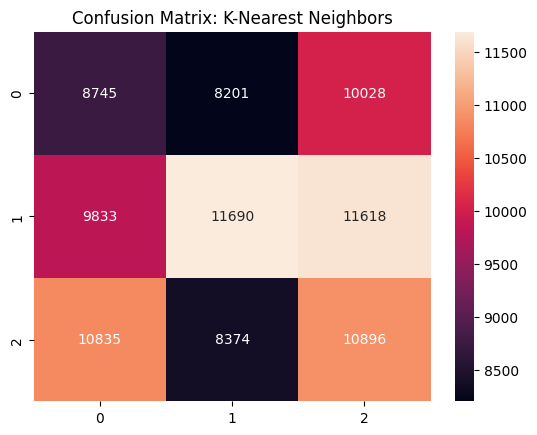

__________________________________
No feature importance or coefficients for K-Nearest Neighbors
____________________________________________
____________________________________________
Processing XGBoost for symbol: SPY
XGBoost - F1 Score: 0.4083864678168511
Confusion Matrix:
 [[ 9601  5896 11477]
 [ 8615 14570  9956]
 [11358  6444 12303]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.32      0.36      0.34     26974
           0       0.54      0.44      0.49     33141
           1       0.36      0.41      0.39     30105

    accuracy                           0.40     90220
   macro avg       0.41      0.40      0.40     90220
weighted avg       0.42      0.40      0.41     90220

Best Hyperparameters:
 {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.9}


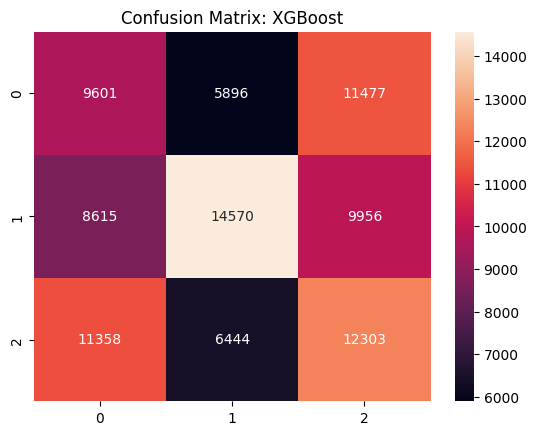

__________________________________
Feature importances for XGBoost:
                       feature  importance
8                          OBV    0.119060
10  WEEKLY_MOVEMENT_SINCE_OPEN    0.113189
7                          ATR    0.112851
13                 DAY_OF_WEEK    0.110957
14                 HOUR_OF_DAY    0.104236
9    DAILY_MOVEMENT_SINCE_OPEN    0.088183
12     PCT_MOVEMENT_60_PERIODS    0.055945
1                  MACD_SIGNAL    0.053688
0                         MACD    0.045925
5      BOLLINGER_WIDTH_PERCENT    0.043691
2                          RSI    0.035300
11     PCT_MOVEMENT_20_PERIODS    0.033904
4                          CCI    0.028146
6           BOLLINGER_POSITION    0.028032
3                 STOCHASTIC_K    0.026892
____________________________________________
____________________________________________
Processing Logistic Regression for symbol: SPY
Logistic Regression - F1 Score: 0.42250608814279267
Confusion Matrix:
 [[12010 10678  4286]
 [ 6572 23372  

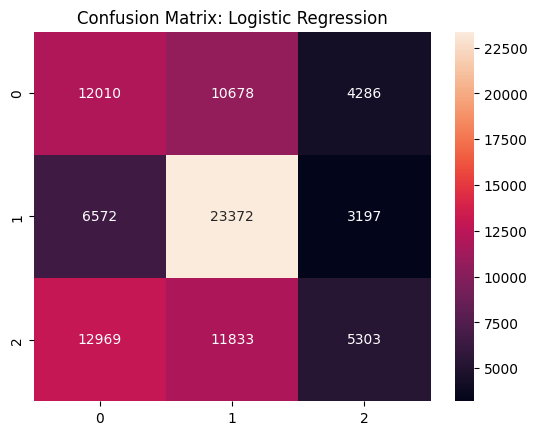

__________________________________
Coefficients for Logistic Regression:
                       feature   coefficient
7                          ATR  2.460965e+00
0                         MACD  3.849225e-01
6           BOLLINGER_POSITION  1.065806e-01
14                 HOUR_OF_DAY  6.899348e-03
13                 DAY_OF_WEEK  6.029933e-03
3                 STOCHASTIC_K  1.741068e-03
4                          CCI  3.147484e-04
1                  MACD_SIGNAL  0.000000e+00
5      BOLLINGER_WIDTH_PERCENT  0.000000e+00
11     PCT_MOVEMENT_20_PERIODS  0.000000e+00
12     PCT_MOVEMENT_60_PERIODS  0.000000e+00
8                          OBV -2.035494e-11
2                          RSI -2.022037e-02
10  WEEKLY_MOVEMENT_SINCE_OPEN -2.355017e-01
9    DAILY_MOVEMENT_SINCE_OPEN -6.570102e+00
____________________________________________
____________________________________________
Processing Random Forest for symbol: SPY
Random Forest - F1 Score: 0.42363709643217895
Confusion Matrix:
 [[ 9367  66

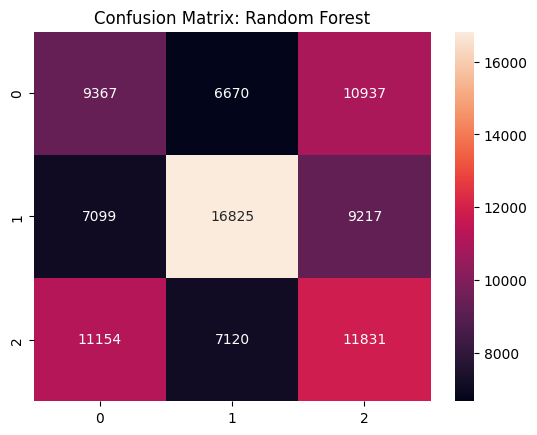

__________________________________
Feature importances for Random Forest:
                       feature  importance
8                          OBV    0.148707
10  WEEKLY_MOVEMENT_SINCE_OPEN    0.140089
9    DAILY_MOVEMENT_SINCE_OPEN    0.113338
7                          ATR    0.103443
5      BOLLINGER_WIDTH_PERCENT    0.066261
12     PCT_MOVEMENT_60_PERIODS    0.064850
1                  MACD_SIGNAL    0.059647
0                         MACD    0.050041
14                 HOUR_OF_DAY    0.044886
13                 DAY_OF_WEEK    0.044393
11     PCT_MOVEMENT_20_PERIODS    0.038660
2                          RSI    0.035161
4                          CCI    0.031613
3                 STOCHASTIC_K    0.029470
6           BOLLINGER_POSITION    0.029441
____________________________________________
____________________________________________
Processing Neural Network for symbol: SPY
Neural Network - F1 Score: 0.3762366424320499
Confusion Matrix:
 [[10291  6956  9727]
 [10825 13209  9107]

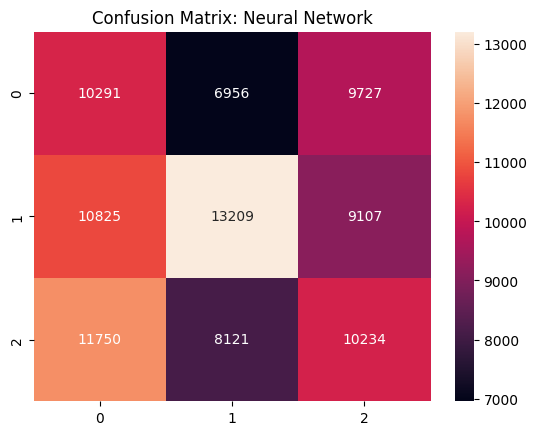

__________________________________
No feature importance or coefficients for Neural Network
____________________________________________
____________________________________________
Processing Gradient Boosting for symbol: SPY
Gradient Boosting - F1 Score: 0.4172373880877149
Confusion Matrix:
 [[ 9382  6133 11459]
 [ 7913 15506  9722]
 [11397  6305 12403]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.33      0.35      0.34     26974
           0       0.55      0.47      0.51     33141
           1       0.37      0.41      0.39     30105

    accuracy                           0.41     90220
   macro avg       0.42      0.41      0.41     90220
weighted avg       0.42      0.41      0.42     90220

Best Hyperparameters:
 {'subsample': 0.9, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.2}


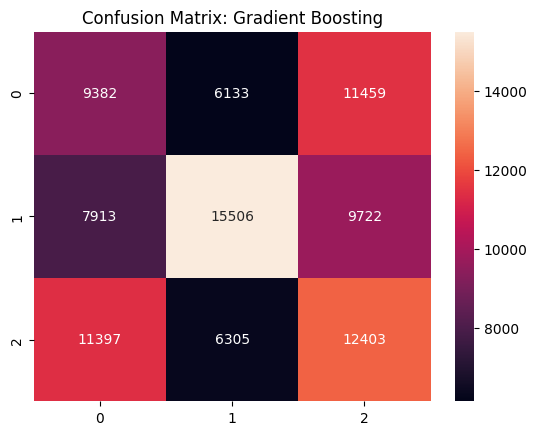

__________________________________
Feature importances for Gradient Boosting:
                       feature  importance
8                          OBV    0.294261
7                          ATR    0.205720
10  WEEKLY_MOVEMENT_SINCE_OPEN    0.193804
9    DAILY_MOVEMENT_SINCE_OPEN    0.111000
14                 HOUR_OF_DAY    0.046776
13                 DAY_OF_WEEK    0.039948
12     PCT_MOVEMENT_60_PERIODS    0.030953
1                  MACD_SIGNAL    0.020311
5      BOLLINGER_WIDTH_PERCENT    0.018485
0                         MACD    0.014083
2                          RSI    0.007977
11     PCT_MOVEMENT_20_PERIODS    0.005381
3                 STOCHASTIC_K    0.004534
4                          CCI    0.003990
6           BOLLINGER_POSITION    0.002779
____________________________________________
____________________________________________
Processing Support Vector Machine for symbol: SPY
Support Vector Machine - F1 Score: 0.42579868426419726
Confusion Matrix:
 [[10266 11244  5464]

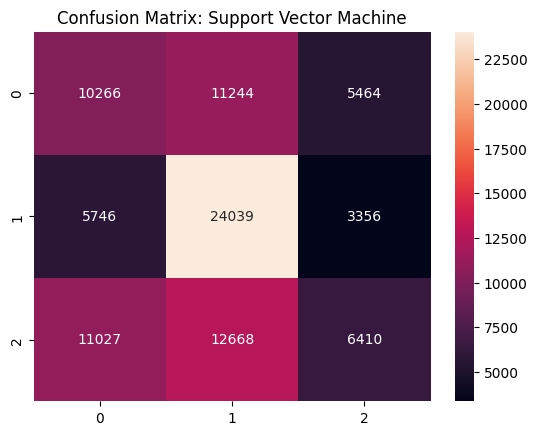

__________________________________
Coefficients for Support Vector Machine:
                       feature  coefficient
7                          ATR     1.153970
14                 HOUR_OF_DAY     0.087839
1                  MACD_SIGNAL     0.052990
6           BOLLINGER_POSITION     0.052818
13                 DAY_OF_WEEK     0.019963
12     PCT_MOVEMENT_60_PERIODS    -0.000008
5      BOLLINGER_WIDTH_PERCENT    -0.003183
4                          CCI    -0.003889
3                 STOCHASTIC_K    -0.008345
11     PCT_MOVEMENT_20_PERIODS    -0.014079
10  WEEKLY_MOVEMENT_SINCE_OPEN    -0.056769
0                         MACD    -0.059267
2                          RSI    -0.097751
8                          OBV    -0.116460
9    DAILY_MOVEMENT_SINCE_OPEN    -0.133895
____________________________________________
____________________________________________
Completed processing for symbol: SPY



In [9]:
# Instantiate and use the trading bot
atb = AlpacaTradingBot()

# Select features, target, and symbol to run our classifaction models on 
symbols = ['SPY']
target = 'TARGET_MOVEMENT_SIGNAL'
features = ['MACD', 'MACD_SIGNAL', 'RSI', 'STOCHASTIC_K', 'CCI', 'BOLLINGER_WIDTH_PERCENT',
            'BOLLINGER_POSITION', 'ATR', 'OBV', 'DAILY_MOVEMENT_SINCE_OPEN', 'WEEKLY_MOVEMENT_SINCE_OPEN',
            'PCT_MOVEMENT_20_PERIODS', 'PCT_MOVEMENT_60_PERIODS', 'DAY_OF_WEEK', 'HOUR_OF_DAY']

# Run models for each symbol
for symbol in symbols:
    print(f"Processing symbol: {symbol}")
    atb.classification_modeling(features, target, symbol)
    print(f"Completed processing for symbol: {symbol}\n")

### Generate Predictions

In [6]:
"""

Query current day's data, insert to stage, add indicators & add model predictions based on already created models.

"""
atb = AlpacaTradingBot()

# Define the list of stocks
stocks = ["SPY"]

# Just query current day's data
# start_date = datetime.now().strftime("%Y-%m-%d")
# end_date = datetime.now().strftime("%Y-%m-%d")

# Step 1: Download ticks and add to stage table
# data = {}
# for stock in stocks:
    # Download historical data
    # stock_data = atb.download_bar_data(stock, TimeFrame(1, TimeFrameUnit.Minute), start_date, end_date)
    # data[stock] = stock_data

# Store all downloaded data in the staging table
# for stock, stock_data in data.items():
#     atb.db_append_no_duplicates('STG_SYMBOL_DATA', stock_data)
#     print(f"Stage table updated with data for {stock}")

# Step 2: Transfer data from the staging table to the modeling staging table
for stock in stocks:
    atb.classification_model_predictions('STG_SYMBOL_DATA', stock, "CLASSIFICATION_MODEL_PREDICTIONS")
    print(f"Model predictions for {stock} stored in CLASSIFICATION_MODEL_PREDICTIONS.")


Predicting with Random_Forest model.
Random_Forest prediction computed for SPY.
Unique predictions for Random_Forest: [ 1  0 -1]
Predicting with XGBoost model.
XGBoost prediction computed for SPY.
Unique predictions for XGBoost: [ 1  0 -1]
Predicting with Gradient_Boosting model.


d:\Scripts\alpaca\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Gradient_Boosting prediction computed for SPY.
Unique predictions for Gradient_Boosting: [ 1 -1]
Predicting with Neural_Network model.
Neural_Network prediction computed for SPY.
Unique predictions for Neural_Network: [ 0  1 -1]
Truncated table CLASSIFICATION_MODEL_PREDICTIONS.
Model predictions stored in CLASSIFICATION_MODEL_PREDICTIONS.
Model predictions for SPY stored in CLASSIFICATION_MODEL_PREDICTIONS.
